In [988]:
import os
import sys
import pandas as pd
import googletrans
from googletrans import Translator
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
import numpy as np
from sklearn.model_selection import GridSearchCV


In [989]:
# Constants
ROOT_PATH = os.path.abspath(os.getcwd())
SEED = 170

# bycode 2018 excel
BYCODE = "bycode2018"

# index 2018 excel
INDEX = "index 2018"
NATURAL = "Natural Area"
DISTRICT = "District"
RELIGION = "Religion"
SETTLEMENT_TYPE = "Settlement Type"


# elections data
CALPI = "calpi"
SETTELMENT = "settelments"


In [990]:
def inner_join(df_1,df_2,column_name):
    """makes inner-join between dataframes on the specified column"""
    return pd.merge(left=df_1, right=df_2, left_on= column_name, right_on=column_name)

def get_index(sheet):
    "returns dataframe of sheet from index 2018 excel"
    path = os.path.join(ROOT_PATH,INDEX+".xlsx")
    return pd.read_excel(path, sheet_name=sheet)

def get_bycode():
    """returns dataframe for bycode excel"""
    path = os.path.join(ROOT_PATH,BYCODE+".xlsx")
    return pd.read_excel(path)

def get_data(agg_type, num):
    """returns dataframe of the requested .xlsx""" 
    if type(num) is not str:
        num = str(num)
        
    path = os.path.join(ROOT_PATH,num+agg_type+".xlsx")
    return pd.read_excel(path,dtype=object)

In [991]:
def remove_small_parties(df,threshold):
    """remove parties that didnt pass the threshold"""
    
    for column in df.columns[7:]:
            if df[column].sum() < threshold:
                   df = df.drop(column,axis=1)
    return df

In [992]:
def total_voters(df):
    "ploting a barchar from dataframe"
    dict={}
    for c in df.columns[7:]:
        dict[c]=(df[c].sum()/df['valid votes'].sum())*100
    plt.figure(figsize=(20,10))
    plt.bar(range(len(dict)), list(dict.values()), align='center')
    plt.ylabel('Voter turnout')
    plt.xlabel('Parties')
    plt.xticks(range(len(dict)), list(dict.keys()))
    plt.show()

In [993]:
def unite_parties (df):
    """ unites small parties to factions
    
    We think those factions represent the israeli society
    """
    
    d={'United Torah Judaism':'Haredi','Shas':'Haredi', 'Avoda':'Left','Meretz':'Left',
       'Consolidation of right-wing parties':'Right','Kolano':'Right','Israel is our Home':'Right','New Right':'Right',
        'UAL-Balad':'Arab','Hadash':'Arab' ,'Gesher Avoda':'Left','Joint list':'Arab','right':'Right'
        ,'Avoda-Meretz-Gesher':'Left'}
    
    faction=['Haredi','Right','Arab','Left']
    for f in faction:
        df.insert(len(df.columns),f ,0)
    for c in  df.columns[7:]:
        if c in d:
            s=df[d[c]]+df[c]
            df[d[c]]=s
   
    for c in d.keys():
        if c in df.columns:
              df=df.drop(c,axis=1)
    return df

In [994]:
def normalize_to_voting_ratios(df_original):
    """normalizing the votes according to proportion of votes per party"""
    df = df_original.copy()
    for i,r in df.iterrows():
        for c in df.columns[2:]:
            x = r[c]/r['valid votes']
            df.at[i , c]=x
    
    colms_to_remove = ["valid votes"]
    df = df.drop(labels = colms_to_remove,axis=1) 
    return df

In [995]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ 
    Returns the angle in radians between vectors 'v1' and 'v2'
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def prepare_vectors(df):
    """calculates the distance and the angle of each vector from the base_vector"""
    
    matrix = [] 
    vector_base = np.zeros(df.shape[1])
    vector_base.fill(1)

    for row in df:
        dist = np.linalg.norm(row)
        angle = angle_between(vector_base,row)
        matrix.append([dist,angle])
        
    return np.array(matrix)
    

In [996]:
def add_most_voted_colm(df):
    """ adds a column of labels for the most voted faction """
    temp = df.copy()
    temp.drop(labels = ["code"],axis=1,inplace = True)
    
    for c in temp.columns:
        temp[c] = pd.to_numeric(temp[c])
    
    colm = temp.idxmax(axis=1)
    df["chosen"] = colm
    return df
        

In [998]:
def barchar_group(df,x_var,groupby_var,size):
    # Prepare data
    df_agg = df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
    vals = [df[x_var].values.tolist() for i, df in df_agg]
    
    # Draw
    plt.figure(figsize=(16,9), dpi= 80)
    colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
    n, bins, patches = plt.hist(vals, df[x_var].unique().__len__(), stacked=False, density=False, color=colors[:len(vals)])
    
    
    # Decoration
    plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(vals)])})
    plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
    plt.xlabel(x_var)
    plt.ylabel("Frequency")
    plt.ylim(0, size)
    plt.xticks(ticks=bins, labels=np.unique(df[x_var]).tolist(), rotation=90, horizontalalignment='left')
    plt.show()

SyntaxError: invalid syntax (<ipython-input-998-e3cae43d9661>, line 11)

In [ ]:
def remove_metadata(df):
    return df.drop(["name","Holders of voting rights","Voters","Disqualified","committee code"],axis=1)   

In [ ]:
df_21 = get_data(SETTELMENT,21)
df_21 = remove_small_parties(df_21,135720)
df = unite_parties(df_21)
df_base = remove_metadata(df)
df_normalized = normalize_to_voting_ratios(df_base)
df_base

In [ ]:
vectors = df_normalized[df_normalized.columns.difference(['code'])]
vectors = prepare_vectors(vectors.values)

In [ ]:
param = {
    "n_clusters":[3,6],
    "init":["k-means++", "random"],
    "n_init": [10],
    "max_iter":[300],
    "precompute_distances":[False,True],
    "random_state":[SEED],
    "algorithm" : ["auto", "full", "elkan"]

}

gs = GridSearchCV(KMeans(), param,  refit=True, cv=[(slice(None), slice(None))], verbose=1)
gs.fit(vectors)
model = gs.best_estimator_
df = df_normalized.copy()
y = model.predict(vectors)

df_base['Cluster Class'] = pd.Series(y, index=df_21.index)


In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.scatter(vectors[:, 0], vectors[:, 1], c=y)
plt.title("Incorrect Number of Blobs")

In [1035]:
bycode = get_bycode()
index = get_index(NATURAL)

df = inner_join(df_base,bycode,"code")
print(df["Likud"].sum())
print(df["Blue and white"].sum())
df = inner_join(df,index,"Natural area code")
df = df[["Cluster Class","Name of Natural Area"]]
print(df_21["Likud"].sum())
print(df_21["Blue and white"].sum())

1070280
1057173
1140370
1125881


In [ ]:
barchar_group(df,"Cluster Class","Name of Natural Area",200)

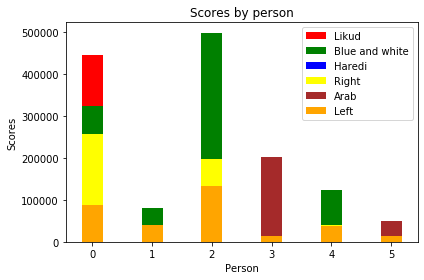

In [1050]:
bycode = get_bycode()
index = get_index(NATURAL)

df = inner_join(df_base,bycode,"code")
df = inner_join(df,index,"Natural area code")
df = df[["Cluster Class","Likud","Blue and white","Haredi","Right","Arab","Left"]]
df = df.groupby("Cluster Class").sum()
df = df.T

# data to plot
n_groups = 6

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

colors = ["red","green","blue","yellow","brown","orange"]
recs =[] 
num = 0
for lb,row in df.iterrows():
    recs.append(plt.bar(index+bar_width, row,bar_width,label=lb,color = colors[num]))
    num += 1

plt.xlabel('Person')
plt.ylabel('Scores')
plt.title('Scores by person')
plt.xticks(index + bar_width, ('0', '1', '2', '3','4', '5'))
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(vectors, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(vectors)
y = ms.labels_
cluster_centers = ms.cluster_centers_
df = df_21.copy()
df['Cluster Class'] = pd.Series(y, index=df_21.index)


In [ ]:
bycode = get_bycode()
index = get_index(NATURAL)

df = inner_join(df_base,bycode,"code")
df = inner_join(df,index,"Natural area code")
df = df[["Cluster Class","Name of Natural Area"]]

In [ ]:
barchar_group(df,"Cluster Class","Name of Natural Area",200)

In [ ]:
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import  metrics
param_grid = {
    'n_estimators': [100, 150, 200, 250],  # The number of trees in the forest.
    'max_depth': [None, 50, 60, 70],  # The maximum depth of the tree.
    'max_features': ['sqrt', None],  # he number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 10],  # The minimum number of samples required to split an internal node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees.
}

df21 = get_data(SETTELMENT,21)
df21 = remove_small_parties(df21,135720)
df21 = unite_parties(df21)
df21=df21[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
           "Blue and white","Haredi","Right","Arab","Left","valid votes"]]
df22 = get_data(SETTELMENT,22)
df22 = remove_small_parties(df22,135720)
df22 = unite_parties(df22)
df22=df22[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
           "Blue and white","Haredi","Right","Arab","Left","valid votes"]]


df23 = get_data(SETTELMENT,23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)
a=["HAIFA","ELAT","AYYELET HASHAHAR","SAKHNIN","QAZRIN"]
df23 = df23[df23.name.isin(a)]
locations=df23[['name']].values.tolist()
df23=df23[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
           "Blue and white","Haredi","Right","Arab","Left","valid votes"]]

df=pd.concat([df21, df22])
x_train=df.iloc[:,:-1]
y_train=df.iloc[:,-1]
x_test=df23.iloc[:,:-1]
y_test=df23.iloc[:,-1]

estimator = RandomForestRegressor(random_state=SEED)

rs = RandomizedSearchCV(estimator, param_grid, n_jobs=-1,
                        scoring='neg_mean_squared_error', cv=5,
                        n_iter=1, verbose=1, random_state=SEED)

rs.fit(x_train,y_train)
predict_y = rs.predict(x_test)
actual=df23.iloc[:,-1].values
i=0
while i< len(predict_y):
        print("predection for "+str(locations[i])+ " is "+str(predict_y[i])+" while the true value is "+
                                    str(actual[i]))
        i=i+1
        
